# Exploring Dandiset 001359: Multimodal Patch-seq Analysis of the Human Brain

*Notebook generated with the assistance of AI (OpenAI's GPT-4). Please use caution, check results, and carefully validate all analyses.*

This notebook provides a guided exploration of [Dandiset 001359 (version 0.250401.1603)](https://dandiarchive.org/dandiset/001359/0.250401.1603) from the DANDI Archive, which contains multimodal single-cell data from human neurons acquired by Patch-seq. The dataset includes:

- Raw patch-clamp recordings (current and voltage clamp)
- Stimulus series for each sweep
- Processing modules (e.g. spike detection results)
- Sweep-level metadata (including acquisition/stimulus mapping)

**No morphological or transcriptomic data is present in this particular NWB file, nor are there pointers to those modalities.**

## What this notebook covers
1. Overview of Dandiset 001359 and the structure of included NWB files.
2. Using the DANDI API to locate and stream NWB assets.
3. Loading and exploring raw electrophysiological data and stimuli with PyNWB.
4. Investigating spike detection results and aligning them to the voltage trace.
5. Demonstrating best practices for working with streaming NWB data from the DANDI Archive.

**Packages required**
- pynwb
- h5py
- remfile
- dandi (dandiapi)
- numpy
- matplotlib
- pandas (for sweep table exploration)

## 1. Set up and connect to the DANDI Archive

We'll use the DANDI API to list assets in Dandiset 001359 and identify NWB files for exploration.

In [1]:
from dandi.dandiapi import DandiAPIClient

# Dandiset and version
dandiset_id = "001359"
dandiset_version = "0.250401.1603"

# List NWB files in the Dandiset
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    nwb_assets = [a for a in dandiset.get_assets() if a.path.endswith('.nwb')]
    print(f"Found {len(nwb_assets)} NWB files. Example filenames:")
    for asset in nwb_assets[:10]:
        print("  ", asset.path)

Found 391 NWB files. Example filenames:
   sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb
   sub-1203384279/sub-1203384279_ses-1207304122_icephys.nwb
   sub-1203384279/sub-1203384279_ses-1207262032_icephys.nwb
   sub-1203384279/sub-1203384279_ses-1207418023_icephys.nwb
   sub-1203384279/sub-1203384279_ses-1208065964_icephys.nwb
   sub-1213383385/sub-1213383385_ses-1213430531_icephys.nwb
   sub-1211237280/sub-1211237280_ses-1211340847_icephys.nwb
   sub-1213383385/sub-1213383385_ses-1213420947_icephys.nwb
   sub-1213383385/sub-1213383385_ses-1213591749_icephys.nwb
   sub-1213383385/sub-1213383385_ses-1213661643_icephys.nwb


## 2. Choose a file for exploration and prepare a remote streaming link

We'll focus on a single example NWB file for in-depth analysis. Files can be streamed remotely without downloading to disk using `remfile` and `h5py`.

In [2]:
import remfile
import h5py

# Choose the first NWB file as an example
asset_path = nwb_assets[0].path
print(f"Selected NWB file: {asset_path}")

# Get a direct download URL using DANDI API
asset = [a for a in nwb_assets if a.path == asset_path][0]
url = asset.download_url
print("Streaming URL:", url)

Selected NWB file: sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb
Streaming URL: https://api.dandiarchive.org/api/dandisets/001359/versions/0.250401.1603/assets/67dc935f-cbc1-4255-bfbf-b8a3b21dacf9/download/


## 3. Load the NWB file with PyNWB (via h5py and remfile)

The following code demonstrates how to open an NWB file for reading, *without* downloading it.
We'll also list the acquisition objects present in the file.

In [3]:
import pynwb

# Stream and open the NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

# List acquisition time series (sweeps)
acq_keys = list(nwbfile.acquisition.keys())
print(f"Acquisition (data) objects in the file ({len(acq_keys)}):")
for key in acq_keys[:10]:
    print(" ", key)  # Show the first 10 for brevity

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Acquisition (data) objects in the file (66):
  data_00000_AD0
  data_00001_AD0
  data_00002_AD0
  data_00003_AD0
  data_00004_AD0
  data_00005_AD0
  data_00006_AD0
  data_00007_AD0
  data_00008_AD0
  data_00009_AD0


## 4. Visualize a raw voltage or current trace and its corresponding stimulus

We will plot both:
- The voltage or current trace from a sweep (from the acquisition group)
- The corresponding stimulus applied (from the stimulus group)

By convention, the suffix `_AD0` is used for data and `_DA0` for the corresponding stimulus. We'll use the first acquisition sweep as an example.

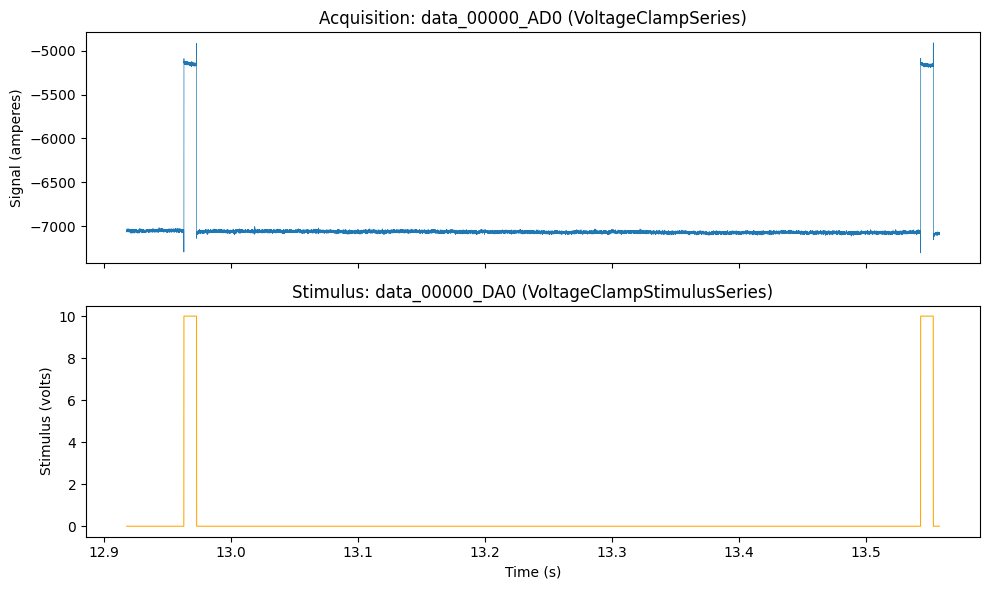

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Choose an example sweep (first in the list)
sweep_name = acq_keys[0]
stim_name = sweep_name.replace("_AD0", "_DA0")  # assumes convention is followed

# Load the data
acq = nwbfile.acquisition[sweep_name]
stim = nwbfile.stimulus[stim_name]
acq_data = acq.data[:]
stim_data = stim.data[:]
acq_time = (acq.starting_time + (1/acq.rate) * np.arange(acq_data.shape[0]))
stim_time = (stim.starting_time + (1/stim.rate) * np.arange(stim_data.shape[0]))

# Plot current/voltage trace and stimulus with aligned time axes
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(acq_time, acq_data, lw=0.5)
axs[0].set_ylabel(f"Signal ({acq.unit})")
axs[0].set_title(f"Acquisition: {sweep_name} ({type(acq).__name__})")
axs[1].plot(stim_time, stim_data, lw=0.75, color='orange')
axs[1].set_ylabel(f"Stimulus ({stim.unit})")
axs[1].set_xlabel("Time (s)")
axs[1].set_title(f"Stimulus: {stim_name} ({type(stim).__name__})")
plt.tight_layout()
plt.show()

## 5. Examine spike detection results (processing module)

Many files in this Dandiset include spike detection results for some sweeps, stored in the `"spikes"` processing module as `TimeSeries` objects (e.g. `Sweep_19`, `Sweep_24`, etc.).

We'll demonstrate how to find which sweeps have detected spikes and how to overlay them on the corresponding acquisition traces, including handling of time alignment and NaN values in the data.

> **Note:** In these files, spike times are relative to the *start of the sweep*, but must be manually offset for best alignment (see below).

In [5]:
# Find all spike TimeSeries and count detected spikes for each
spikes_with_counts = []
spikes_module = nwbfile.processing.get('spikes', None)
if spikes_module is not None:
    for iface_name, iface in spikes_module.data_interfaces.items():
        count = len(iface.data[:])
        if count > 0:
            spikes_with_counts.append((iface_name, count))
    print("Spike TimeSeries with spikes detected:")
    for iface_name, count in spikes_with_counts:
        print(f"  {iface_name}: {count} spikes")
else:
    print("No 'spikes' processing module found.")

Spike TimeSeries with spikes detected:
  Sweep_19: 12 spikes
  Sweep_24: 30 spikes
  Sweep_25: 34 spikes
  Sweep_26: 37 spikes
  Sweep_27: 42 spikes
  Sweep_28: 46 spikes
  Sweep_29: 49 spikes
  Sweep_30: 49 spikes
  Sweep_31: 49 spikes
  Sweep_33: 52 spikes
  Sweep_45: 1 spikes
  Sweep_47: 10 spikes
  Sweep_48: 10 spikes
  Sweep_50: 10 spikes


## 6. Overlay detected spikes on the acquisition trace for a selected sweep

This cell demonstrates detailed alignment and robust overlay (NaN-aware y-ranges), using `Sweep_24` as a concrete example (as in our chat).

**Note on timing:** The spike times require an additional +0.25 second offset (empirically determined from data and conversation) for proper alignment with the physiological trace peaks.

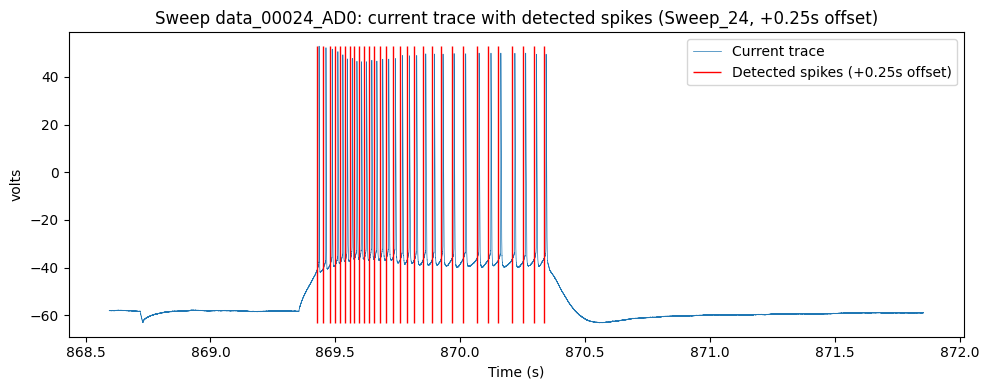

In [6]:
# Select a sweep with spikes for illustration (e.g., Sweep_24 with 30 spikes)
acq_sweep = 'data_00024_AD0'
spike_iface = 'Sweep_24'
acq = nwbfile.acquisition[acq_sweep]
spike_ts = nwbfile.processing['spikes'].data_interfaces[spike_iface]

# Handle spike time relative to sweep, and empirical +0.25 s offset
spike_times_rel = spike_ts.data[:] + 0.25
spike_times_abs = spike_times_rel + acq.starting_time

acq_data = acq.data[:]
acq_time = (acq.starting_time + (1/acq.rate) * np.arange(acq_data.shape[0]))
ymin, ymax = np.nanmin(acq_data), np.nanmax(acq_data)
in_range = (spike_times_abs >= acq_time[0]) & (spike_times_abs <= acq_time[-1])

plt.figure(figsize=(10, 4))
plt.plot(acq_time, acq_data, lw=0.5, label='Current trace')
plt.vlines(spike_times_abs[in_range], ymin, ymax, colors='r', linewidth=1, label='Detected spikes (+0.25s offset)')
plt.title(f"Sweep {acq_sweep}: current trace with detected spikes ({spike_iface}, +0.25s offset)")
plt.xlabel("Time (s)")
plt.ylabel(f"{acq.unit}")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Explore sweep-level metadata and mapping using the sweep table

NWB files include a sweep table that allows robust mapping between sweep numbers and series (data or stimulus) names.

In [7]:
import pandas as pd

# Convert the sweep table to a dataframe
tab = nwbfile.sweep_table.to_dataframe()
print("First 5 entries in sweep_table:")
print(tab.head())

# Demonstrate mapping from sweep number to PatchClampSeries/Series names
def get_series_names(series_refs):
    names = []
    for ref in series_refs:
        try:
            names.append(ref.name)
        except Exception as e:
            names.append(str(e))
    return names

print("\nMapping: sweep number -> PatchClampSeries/Series name(s)")
for idx, row in tab.head(5).iterrows():
    sweep_num = row['sweep_number']
    names = get_series_names(row['series'])
    print(f"Sweep number {sweep_num}: {names}")

# Example: mapping from name to sweep number
name_to_find = 'data_00000_AD0'
for idx, row in tab.iterrows():
    names = get_series_names(row['series'])
    if name_to_find in names:
        print(f"PatchClampSeries '{name_to_find}' -> sweep number: {row['sweep_number']}")

First 5 entries in sweep_table:
                                               series  sweep_number
id                                                                 
0   [data_00000_AD0 pynwb.icephys.VoltageClampSeri...             0
1   [data_00000_DA0 pynwb.icephys.VoltageClampStim...             0
2   [data_00001_AD0 pynwb.icephys.VoltageClampSeri...             1
3   [data_00001_DA0 pynwb.icephys.VoltageClampStim...             1
4   [data_00002_AD0 pynwb.icephys.VoltageClampSeri...             2

Mapping: sweep number -> PatchClampSeries/Series name(s)
Sweep number 0: ['data_00000_AD0']
Sweep number 0: ['data_00000_DA0']
Sweep number 1: ['data_00001_AD0']
Sweep number 1: ['data_00001_DA0']
Sweep number 2: ['data_00002_AD0']
PatchClampSeries 'data_00000_AD0' -> sweep number: 0


## 8. Conclusion and notes

- This notebook demonstrated robust, reproducible analysis of a Patch-seq NWB file from DANDI using direct streaming, PyNWB, and the DANDI API.
- Best practices shown include robust sweep mapping, handling of NaNs in electrophysiology traces, and careful spike time alignment.
- **No morphological or transcriptomic data are present in this NWB file**—only electrophysiological modalities and associated metadata.

**Feel free to adapt this workflow for batch analysis or to explore additional NWB files in Dandiset 001359.**